# Trying Ensembling

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import accuracy_score

In [2]:
train_df = pd.read_csv('../data/Final Data/training_with_preds.csv')
train_df = train_df.reset_index(drop=True)
train_df_orig = train_df.copy()

In [3]:
test_df = pd.read_csv('../data/Final Data/start_to_finish_with_preds.csv')
test_df_orig = test_df.copy()

### Preprocess Data

Getting it ready to train and keeping only the rows where 2/3 or more of the models get it wrong.

In [4]:
xgb_train_pred = train_df.xgb_train_pred
knn_no_bat_train_pred = train_df.knn_no_batting_train_pred
nn_train_pred = train_df.nn_train_pred

xgb_train_pred = xgb_train_pred.astype(int)
knn_no_bat_train_pred = knn_no_bat_train_pred.astype(int)

In [5]:
train_df['add'] = train_df['xgb_train_pred'] + train_df['knn_no_batting_train_pred'] + train_df['nn_train_pred']

In [6]:
conditions = [(train_df['add'] >= 2) & (train_df['home_win'] == 1) | (train_df['add'] < 2) & (train_df['home_win'] == 0)]     #Sets the conditions
choices = [1]
train_df['should_drop'] = np.select(conditions, choices, 0)

In [7]:
train_df['should_drop'].value_counts()

1    24658
0    12535
Name: should_drop, dtype: int64

In [8]:
# Get only the customers who did not churn
train_1_df = train_df[train_df['should_drop'] == 0]
# Then select 3620 of them to match the 3620 "No" churn customers
train_1_df = train_1_df.sample(24658, replace=True)

# Also grab the churning customers
train_0_df = train_df[train_df['should_drop'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
oversample_df = pd.concat([train_0_df, train_1_df])

### Oversampling Model

In [9]:
cols_to_drop = ['home_team', 'away_team', 'should_drop', 'xgb_train_pred', 'nn_train_pred', 'knn_no_batting_train_pred', 'add'] + ['xgb_pred', 'nn_pred', 'knn_pred', 'knn_no_batting_pred', 'xgb_proba', 'nn_proba', 'knn_proba','knn_no_batting_proba', 'home_team', 'away_team']
train_cols_to_drop = list(set(oversample_df.columns).intersection(set(cols_to_drop)))
test_cols_to_drop = list(set(test_df.columns).intersection(set(cols_to_drop)))

oversample_df = oversample_df.drop(train_cols_to_drop, axis=1)
test_df = test_df.drop(test_cols_to_drop, axis=1)

In [10]:
common_cols = list(set(oversample_df.columns).intersection(set(test_df.columns)))

test_df = test_df[common_cols]
oversample_df = oversample_df[common_cols]

In [11]:
X_train = oversample_df.drop('home_win', axis=1)
y_train = oversample_df.home_win.astype(int)
X_test = test_df.drop('home_win', axis=1)
y_test = test_df.home_win.astype(int)

In [12]:
params = {'n_estimators': 100,
         'max_depth': 5,
         'min_child_weight': 0.3256355793000354,
         'eta': 0.3076951770384403,
         'subsample': 0.8242904472901268,
         'colsample_bytree': 0.9475703665037462,
         'gamma': 9.66425615956974,
         'seed': 0,
         'nthread': 4,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'}

xgb_oversample_clf = xgb.XGBClassifier(**params)

xgb_oversample_clf.fit(X_train, y_train)

/Users/psavala/.virtualenvs/baseball/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
xgb_oversample_preds = xgb_oversample_clf.predict(X_test)

In [15]:
accuracy_score(y_test, xgb_oversample_preds)

0.544173878043872

In [54]:
feature_df_over = pd.DataFrame(xgb_oversample_clf.feature_importances_, X_train.columns)   #This makes it in order
feature_df_over = feature_df_over.sort_values(by=0, ascending=True)

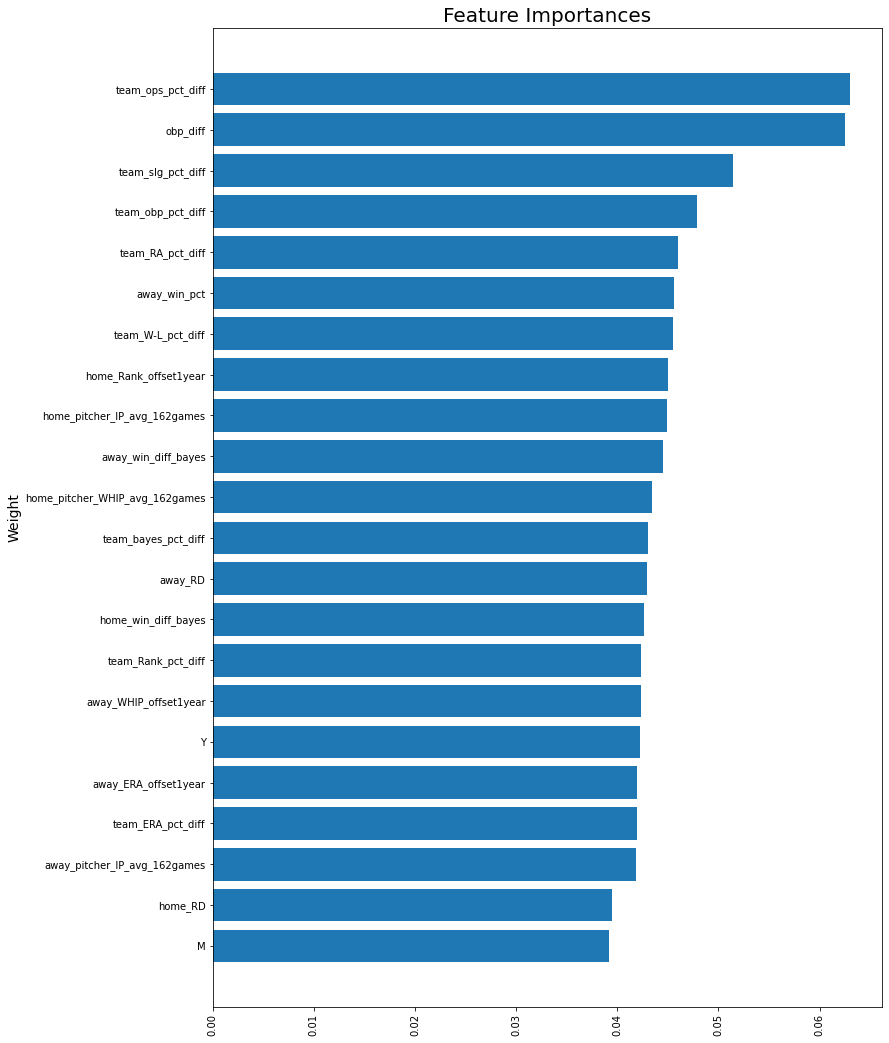

In [55]:
plt.figure(figsize=(12, 18))

x = feature_df_over.index
y = feature_df_over[0]

plt.barh(x, y)
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14);

### Undersample Model

In [18]:
train_df['should_drop'].value_counts()

1    24658
0    12535
Name: should_drop, dtype: int64

In [19]:
# Get only the customers who did not churn
train_1_df = train_df[train_df['should_drop'] == 1]
# Then select 3620 of them to match the 3620 "No" churn customers
train_1_df = train_1_df.sample(12535)

# Also grab the churning customers
train_0_df = train_df[train_df['should_drop'] == 0]

# And now stick both DataFrames together to make a new undersampled training set
undersample_df = pd.concat([train_0_df, train_1_df])

In [20]:
cols_to_drop = ['home_team', 'away_team', 'should_drop', 'xgb_train_pred', 'nn_train_pred', 'knn_no_batting_train_pred', 'add'] + ['xgb_pred', 'nn_pred', 'knn_pred', 'knn_no_batting_pred', 'xgb_proba', 'nn_proba', 'knn_proba','knn_no_batting_proba', 'home_team', 'away_team']
train_cols_to_drop = list(set(undersample_df.columns).intersection(set(cols_to_drop)))
test_cols_to_drop = list(set(test_df.columns).intersection(set(cols_to_drop)))

undersample_df = undersample_df.drop(train_cols_to_drop, axis=1)
test_df = test_df.drop(test_cols_to_drop, axis=1)

In [21]:
common_cols = list(set(undersample_df.columns).intersection(set(test_df.columns)))

test_df = test_df[common_cols]
undersample_df = undersample_df[common_cols]

In [22]:
X_train = undersample_df.drop('home_win', axis=1)
y_train = undersample_df.home_win.astype(int)
X_test = test_df.drop('home_win', axis=1)
y_test = test_df.home_win.astype(int)

In [23]:
params = {'n_estimators': 100,
         'max_depth': 5,
         'min_child_weight': 0.3256355793000354,
         'eta': 0.3076951770384403,
         'subsample': 0.8242904472901268,
         'colsample_bytree': 0.9475703665037462,
         'gamma': 9.66425615956974,
         'seed': 0,
         'nthread': 4,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'}

In [24]:
xgb_undersample_clf = xgb.XGBClassifier(**params)

In [25]:
xgb_undersample_clf.fit(X_train, y_train)

/Users/psavala/.virtualenvs/baseball/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
xgb_undersample_preds = xgb_undersample_clf.predict(X_test)

test_acc = accuracy_score(y_test, xgb_undersample_preds)
print(f'Test acc = {100*test_acc:.2f}%')

Test acc = 51.90%


In [52]:
feature_df_under = pd.DataFrame(xgb_undersample_clf.feature_importances_, X_train.columns)   #This makes it in order
feature_df_under = feature_df_under.sort_values(by=0, ascending=True)

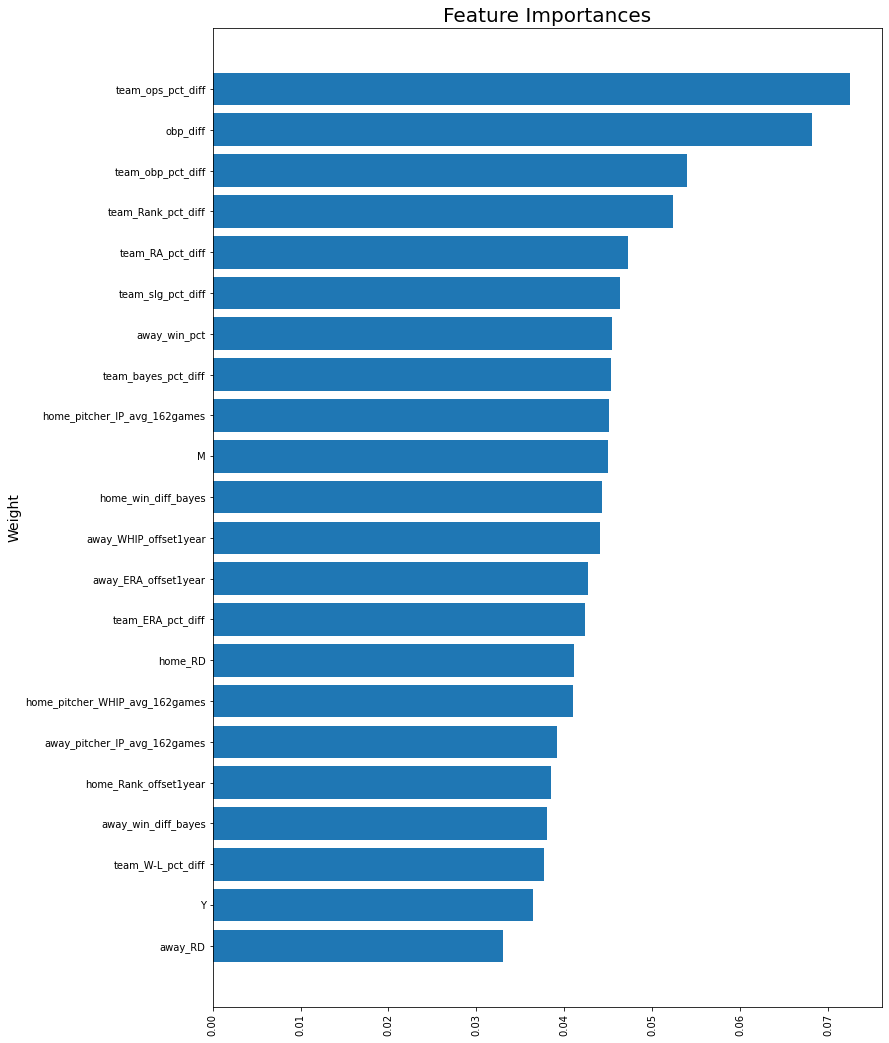

In [53]:
plt.figure(figsize=(12, 18))

x = feature_df_under.index
y = feature_df_under[0]

plt.barh(x, y)
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14);

## Undersampled vs oversampled feature importances

In [58]:
feature_df_under.index

Index(['away_RD', 'Y', 'team_W-L_pct_diff', 'away_win_diff_bayes',
       'home_Rank_offset1year', 'away_pitcher_IP_avg_162games',
       'home_pitcher_WHIP_avg_162games', 'home_RD', 'team_ERA_pct_diff',
       'away_ERA_offset1year', 'away_WHIP_offset1year', 'home_win_diff_bayes',
       'M', 'home_pitcher_IP_avg_162games', 'team_bayes_pct_diff',
       'away_win_pct', 'team_slg_pct_diff', 'team_RA_pct_diff',
       'team_Rank_pct_diff', 'team_obp_pct_diff', 'obp_diff',
       'team_ops_pct_diff'],
      dtype='object')

In [59]:
feature_df_over.index

Index(['M', 'home_RD', 'away_pitcher_IP_avg_162games', 'team_ERA_pct_diff',
       'away_ERA_offset1year', 'Y', 'away_WHIP_offset1year',
       'team_Rank_pct_diff', 'home_win_diff_bayes', 'away_RD',
       'team_bayes_pct_diff', 'home_pitcher_WHIP_avg_162games',
       'away_win_diff_bayes', 'home_pitcher_IP_avg_162games',
       'home_Rank_offset1year', 'team_W-L_pct_diff', 'away_win_pct',
       'team_RA_pct_diff', 'team_obp_pct_diff', 'team_slg_pct_diff',
       'obp_diff', 'team_ops_pct_diff'],
      dtype='object')

In [61]:
feature_df_over

,0
M,0.039232
home_RD,0.039462
away_pitcher_IP_avg_162games,0.041819
team_ERA_pct_diff,0.041954
away_ERA_offset1year,0.041987
Y,0.042250
away_WHIP_offset1year,0.042355
team_Rank_pct_diff,0.042382
home_win_diff_bayes,0.042644
away_RD,0.042964


In [62]:
feature_df_under

,0
away_RD,0.032991
Y,0.036451
team_W-L_pct_diff,0.037725
away_win_diff_bayes,0.038006
home_Rank_offset1year,0.038544
away_pitcher_IP_avg_162games,0.039222
home_pitcher_WHIP_avg_162games,0.041042
home_RD,0.041141
team_ERA_pct_diff,0.042398
away_ERA_offset1year,0.042707


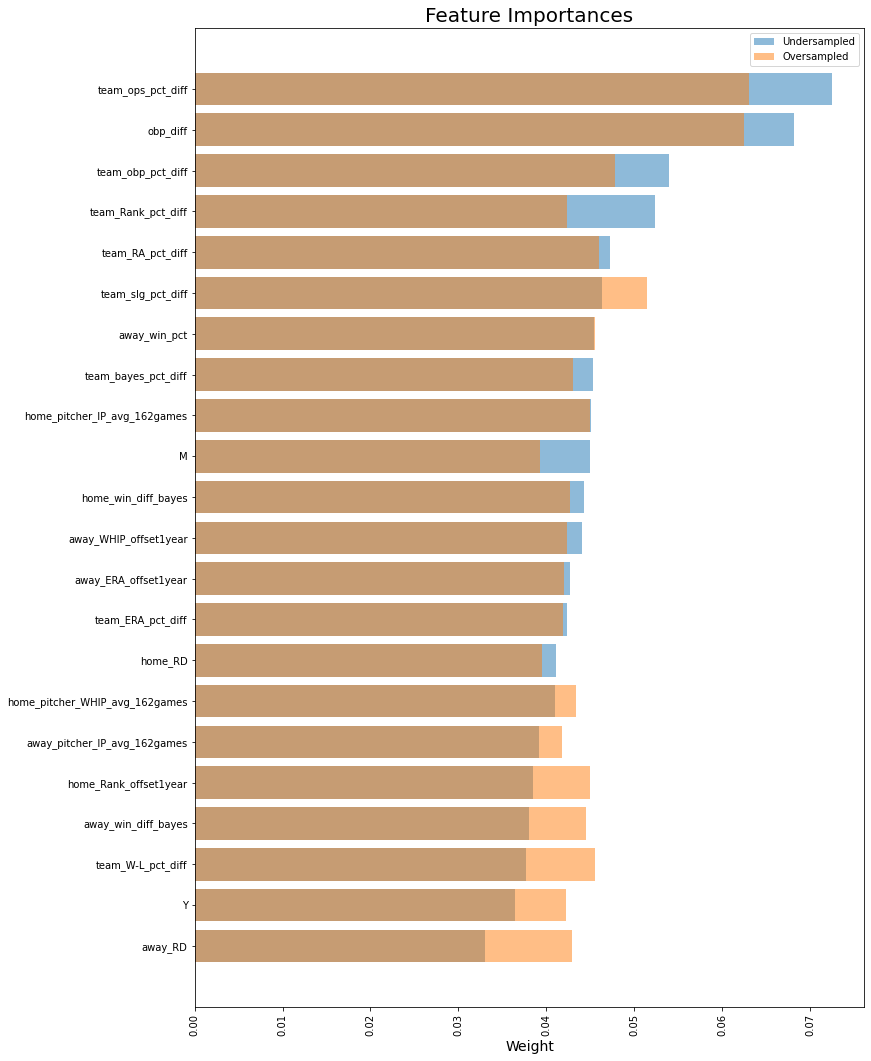

In [63]:
plt.figure(figsize=(12, 18))

plt.barh(feature_df_under.index, feature_df_under[0], alpha=0.5, label='Undersampled')
plt.barh(feature_df_over.index, feature_df_over[0], alpha=0.5, label='Oversampled')
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.xlabel('Weight', fontsize=14)
plt.legend();

### Loading Previous XGB Model 

In [29]:
df = pd.read_csv('../data/Final Data/start_to_finish_with_preds.csv')

In [30]:
df['xgb_oversample_pred'] = xgb_oversample_preds
df['xgb_undersample_pred'] = xgb_undersample_preds

## Comparing Results with each other

In [31]:
num_correct = 0

for i in range(y_test.shape[0]):
    if y_test.values[i] in [xgb_oversample_preds[i], xgb_undersample_preds[i]]:
        num_correct += 1

print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Maximum possible accuracy = 70.27%


In [32]:
conditions = [(df['xgb_undersample_pred'] != df['xgb_oversample_pred'])]     #Sets the conditions
choices = [1]
df['disagree_over_under'] = np.select(conditions, choices, 0)

In [33]:
conditions = [(df['xgb_undersample_pred'] == df['xgb_oversample_pred'])]     #Sets the conditions
choices = [1]
df['agree_over_under'] = np.select(conditions, choices, 0)

In [34]:
disagree_df = df[df['disagree_over_under'] == 1]
agree_df = df[df['agree_over_under'] == 1]

In [35]:
disagree_df.shape[0]

3400

In [36]:
agree_correct_pct = agree_df[agree_df['xgb_undersample_pred'] == agree_df['home_win']].shape[0] / agree_df.shape[0]

print(f'{round(agree_correct_pct*100,2)}%')

54.8%


## Comparing Results to Main XGB

In [37]:
xgb_main_pred = df.xgb_pred

In [38]:
num_correct = 0

for i in range(y_test.shape[0]):
    if y_test.values[i] in [xgb_oversample_preds[i], xgb_main_pred[i], xgb_undersample_preds[i]]:
        num_correct += 1

print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Maximum possible accuracy = 86.45%


#### Main and Oversampling

In [39]:
conditions = [(df['xgb_pred'] != df['xgb_oversample_pred'])]     #Sets the conditions
choices = [1]
df['disagree_over_main'] = np.select(conditions, choices, 0)

In [40]:
conditions = [(df['xgb_pred'] == df['xgb_oversample_pred'])]     #Sets the conditions
choices = [1]
df['agree_over_main'] = np.select(conditions, choices, 0)

In [41]:
disagree_df = df[df['disagree_over_main'] == 1]
agree_df = df[df['agree_over_main'] == 1]

In [42]:
disagree_df.shape[0]

4150

In [43]:
agree_correct_pct = agree_df[agree_df['xgb_pred'] == agree_df['home_win']].shape[0] / agree_df.shape[0]

print(f'{round(agree_correct_pct*100,2)}%')

63.3%


#### Main and Undersampling

In [44]:
conditions = [(df['xgb_pred'] != df['xgb_undersample_pred'])]     #Sets the conditions
choices = [1]
df['disagree_under_main'] = np.select(conditions, choices, 0)

In [45]:
conditions = [(df['xgb_pred'] == df['xgb_undersample_pred'])]     #Sets the conditions
choices = [1]
df['agree_under_main'] = np.select(conditions, choices, 0)

In [46]:
disagree_df = df[df['disagree_under_main'] == 1]
agree_df = df[df['agree_under_main'] == 1]

In [47]:
disagree_df.shape[0]

4722

In [48]:
agree_correct_pct = agree_df[agree_df['xgb_pred'] == agree_df['home_win']].shape[0] / agree_df.shape[0]

print(f'{round(agree_correct_pct*100,2)}%')

62.37%


## Ensembling

### Majority voting

Majority voting with original XGB + XGB over + XGB under

In [67]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    majority_vote = np.sum([xgb_main_pred[i], xgb_undersample_preds[i], xgb_oversample_preds[i]])
    if majority_vote > 1:
        majority_vote = 1
    else:
        majority_vote = 0
    if y_test.values[i] == majority_vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Majority voting accuracy = 56.25%


## Strength of predictions

How does predicted probability compare with results?

In [68]:
# Adjust predicted probability to be between 0 and 1, with 0 meaning a predicted
# probability of 0.5, and 1 being either a predicted probability of 0 or 1 (in other
# words, complete confidence)
def adjust_proba(x):
    if x > 0.5:
        return 2*(x - 0.5)
    else:
        return 2*(1 - x - 0.5)

In [69]:
df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,knn_no_batting_proba,nn_proba,xgb_oversample_pred,xgb_undersample_pred,disagree_over_under,agree_over_under,disagree_over_main,agree_over_main,disagree_under_main,agree_under_main
0,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0.520000,0.455505,0,0,0,1,0,1,0,1
1,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,0.506667,0.395637,0,0,0,1,0,1,0,1
2,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,0.546667,0.508145,0,0,0,1,1,0,1,0
3,0.031095,0.006132,0.019876,5.0,1.320066,0.043269,-0.010464,-35.0,0.0,-0.010464,...,0.506667,0.525333,0,0,0,1,1,0,1,0
4,-0.026164,-0.014945,-0.049505,3.0,1.151872,0.147208,-0.010464,-14.0,0.0,-0.010464,...,0.486667,0.497620,0,0,0,1,1,0,1,0


In [72]:
df['xgb_undersample_proba'] = xgb_undersample_clf.predict_proba(X_test)[:, 1]
df['xgb_oversample_proba'] = xgb_undersample_clf.predict_proba(X_test)[:, 1]

df['xgb_undersample_proba_scaled'] = df['xgb_undersample_proba'].apply(adjust_proba)
df['xgb_oversample_proba_scaled'] = df['xgb_oversample_proba'].apply(adjust_proba)
df['xgb_main_proba_scaled'] = df['xgb_proba'].apply(adjust_proba)

In [75]:
df['xgb_main_correct'] = df['xgb_pred'] == df['home_win']
df['xgb_undersample_correct'] = df['xgb_undersample_pred'] == df['home_win']
df['xgb_oversample_correct'] = df['xgb_oversample_pred'] == df['home_win']

In [76]:
df.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,disagree_under_main,agree_under_main,xgb_undersample_proba,xgb_oversample_proba,xgb_undersample_proba_scaled,xgb_oversample_proba_scaled,xgb_main_proba_scaled,xgb_main_correct,xgb_undersample_correct,xgb_oversample_correct
0,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,0,1,0.449442,0.449442,0.101116,0.101116,0.094638,False,False,False
1,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,0,1,0.302884,0.302884,0.394233,0.394233,0.245543,True,True,True
2,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,1,0,0.399193,0.399193,0.201613,0.201613,0.259434,True,False,False
3,0.031095,0.006132,0.019876,5.0,1.320066,0.043269,-0.010464,-35.0,0.0,-0.010464,...,1,0,0.390716,0.390716,0.218569,0.218569,0.145007,False,True,True
4,-0.026164,-0.014945,-0.049505,3.0,1.151872,0.147208,-0.010464,-14.0,0.0,-0.010464,...,1,0,0.396566,0.396566,0.206869,0.206869,0.031748,False,True,True


In [77]:
df.columns

Index(['team_ops_pct_diff', 'obp_diff', 'team_obp_pct_diff',
       'home_Rank_offset1year', 'away_WHIP_offset1year', 'team_ERA_pct_diff',
       'home_win_diff_bayes', 'home_RD', 'team_bayes_pct_diff',
       'away_win_diff_bayes', 'team_RA_pct_diff', 'team_slg_pct_diff',
       'team_W-L_pct_diff', 'away_ERA_offset1year', 'away_win_pct',
       'away_pitcher_IP_avg_162games', 'team_Rank_pct_diff',
       'home_pitcher_IP_avg_162games', 'away_RD',
       'home_pitcher_WHIP_avg_162games', 'Y', 'M', 'home_win', 'home_team',
       'away_team', 'xgb_pred', 'knn_pred', 'knn_no_batting_pred', 'nn_pred',
       'xgb_proba', 'knn_proba', 'knn_no_batting_proba', 'nn_proba',
       'xgb_oversample_pred', 'xgb_undersample_pred', 'disagree_over_under',
       'agree_over_under', 'disagree_over_main', 'agree_over_main',
       'disagree_under_main', 'agree_under_main', 'xgb_undersample_proba',
       'xgb_oversample_proba', 'xgb_undersample_proba_scaled',
       'xgb_oversample_proba_scaled', 'xg

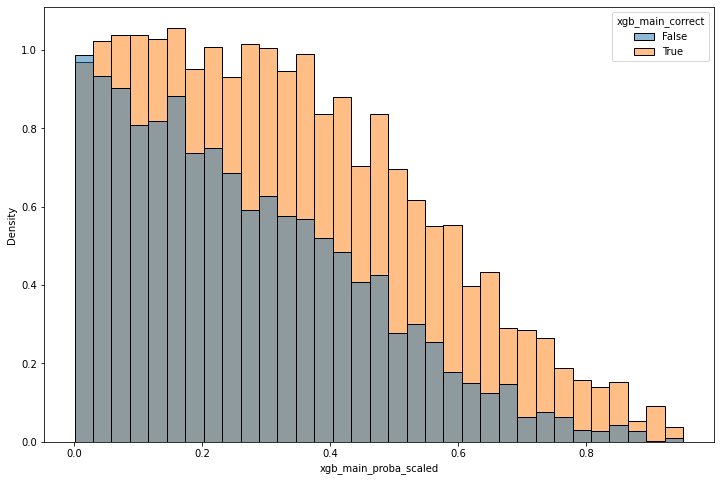

In [78]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='xgb_main_proba_scaled', hue='xgb_main_correct', stat='density');

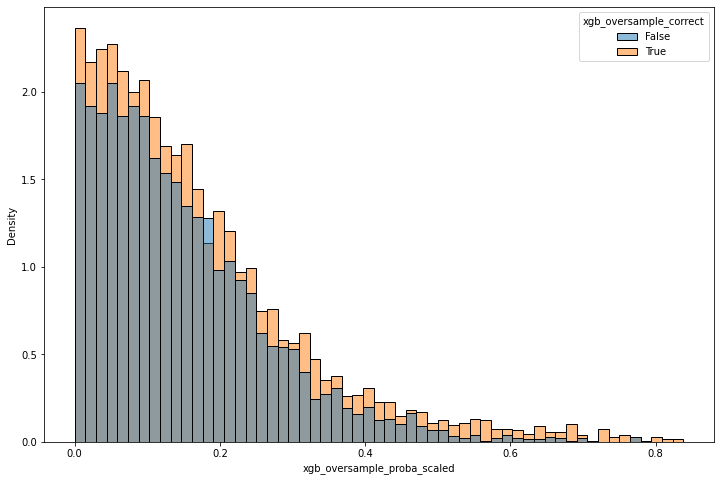

In [79]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='xgb_oversample_proba_scaled', hue='xgb_oversample_correct', stat='density');

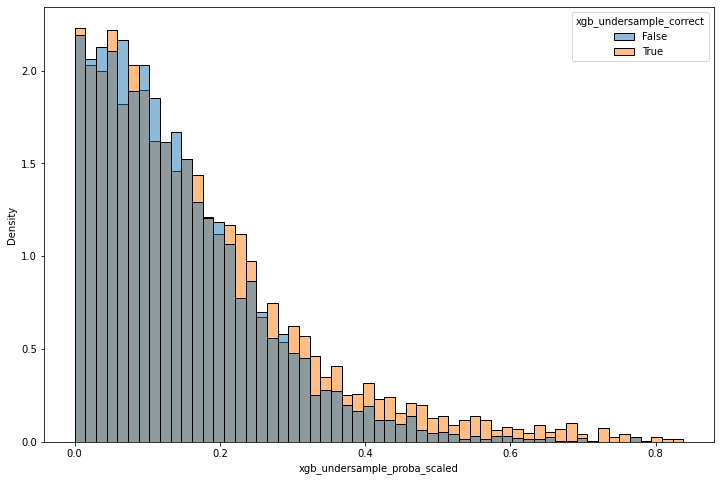

In [80]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='xgb_undersample_proba_scaled', hue='xgb_undersample_correct', stat='density');

## XGB main on high proba games

How does XGB main perform if we restrict it to games on which is has high (scaled) predicted probability?

In [136]:
cutoffs = np.linspace(0, 1, 50)
pct_correct_main = np.zeros_like(cutoffs)

for i, c in enumerate(cutoffs):
    sub_df = df[df['xgb_main_proba_scaled'] > c]
    if sub_df.shape[0] > 0:
        acc = sub_df[sub_df['xgb_pred'] == sub_df['home_win']].shape[0] / sub_df.shape[0]
    else:
        acc = 1
    pct_correct_main[i] = acc

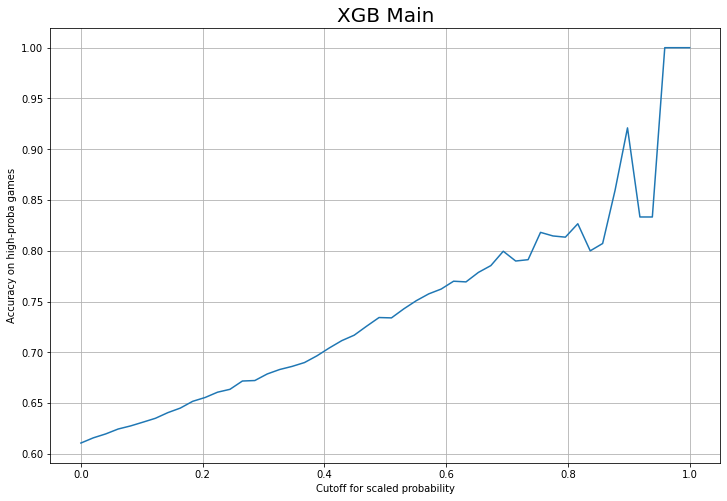

In [137]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, pct_correct_main)
plt.ylabel('Accuracy on high-proba games')
plt.xlabel('Cutoff for scaled probability')
plt.title('XGB Main', fontsize=20)
plt.grid();

## Under and oversample accuracy on low proba XGB games

When XGB main has low scaled predicted probability, how do the other two models do?

In [108]:
pct_correct_under = np.zeros_like(cutoffs)

for i, c in enumerate(cutoffs):
    sub_df = df[df['xgb_main_proba_scaled'] < c]
    if sub_df.shape[0] > 0:
        acc = sub_df[sub_df['xgb_undersample_pred'] == sub_df['home_win']].shape[0] / sub_df.shape[0]
    else:
        acc = 0
    pct_correct_under[i] = acc

In [109]:
pct_correct_over = np.zeros_like(cutoffs)

for i, c in enumerate(cutoffs):
    sub_df = df[df['xgb_main_proba_scaled'] < c]
    if sub_df.shape[0] > 0:
        acc = sub_df[sub_df['xgb_oversample_pred'] == sub_df['home_win']].shape[0] / sub_df.shape[0]
    else:
        acc = 0
    pct_correct_over[i] = acc

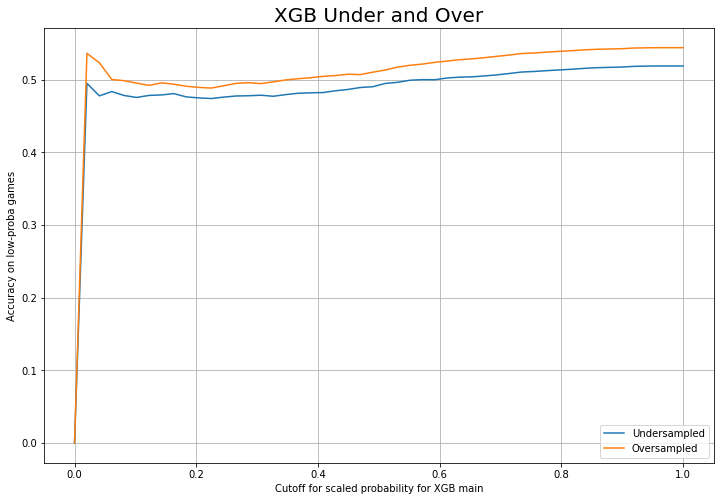

In [110]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, pct_correct_under, label='Undersampled')
plt.plot(cutoffs, pct_correct_over, label='Oversampled')
plt.ylabel('Accuracy on low-proba games')
plt.xlabel('Cutoff for scaled probability for XGB main')
plt.title('XGB Under and Over', fontsize=20)
plt.legend()
plt.grid();

The above graph uses the predicted probability of XGB main as the cutoff. What about if we use the models own predicted probability?

In [111]:
pct_correct_under = np.zeros_like(cutoffs)

for i, c in enumerate(cutoffs):
    sub_df = df[df['xgb_undersample_proba_scaled'] > c]
    if sub_df.shape[0] > 0:
        acc = sub_df[sub_df['xgb_undersample_pred'] == sub_df['home_win']].shape[0] / sub_df.shape[0]
    else:
        acc = 1
    pct_correct_under[i] = acc

In [112]:
pct_correct_over = np.zeros_like(cutoffs)

for i, c in enumerate(cutoffs):
    sub_df = df[df['xgb_oversample_proba_scaled'] > c]
    if sub_df.shape[0] > 0:
        acc = sub_df[sub_df['xgb_oversample_pred'] == sub_df['home_win']].shape[0] / sub_df.shape[0]
    else:
        acc = 1
    pct_correct_over[i] = acc

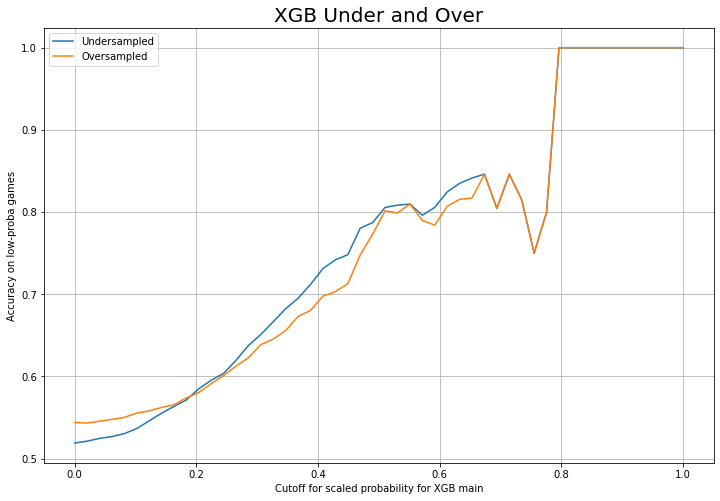

In [113]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, pct_correct_under, label='Undersampled')
plt.plot(cutoffs, pct_correct_over, label='Oversampled')
plt.ylabel('Accuracy on low-proba games')
plt.xlabel('Cutoff for scaled probability for XGB main')
plt.title('XGB Under and Over', fontsize=20)
plt.legend()
plt.grid();

Though both do much better with higher predicted probabilities.

So how many games are there where none of the models are confident enough in their predictions to guarantee (say) 65% accuracy or better?

In [138]:
def cutoff_by_acc(acc):
    main_cutoff = cutoffs[np.where(pct_correct_main>acc)[0][0]]
    under_cutoff = cutoffs[np.where(pct_correct_under>acc)[0][0]]
    over_cutoff = cutoffs[np.where(pct_correct_over>acc)[0][0]]
    return main_cutoff, under_cutoff, over_cutoff

In [139]:
main_65_cutoff, under_65_cutoff, over_65_cutoff = cutoff_by_acc(0.65)

In [140]:
main_65_cutoff, under_65_cutoff, over_65_cutoff

(0.18367346938775508, 0.3061224489795918, 0.3469387755102041)

In [141]:
total_low_proba = df[(df['xgb_main_proba_scaled'] < main_65_cutoff)&(df['xgb_oversample_proba_scaled'] < over_65_cutoff)&(df['xgb_undersample_proba_scaled'] < under_65_cutoff)].shape[0]
pct_low_proba = total_low_proba / df.shape[0]

print(f'{total_low_proba} low probability games ({100*pct_low_proba:.2f}%)')

3241 low probability games (32.61%)


### Ensemble by predicted probability

If XGB has a high enough scaled predicted probability, use its prediction. If not, and one of the other two models (over/under) have a scaled predicted probability above their threshold, use one of their predictions. If none do, use XGB main anyway.

In [146]:
acc_list = []
acc_range = np.linspace(0.5, 0.9, 50)

for acc in acc_range:
    ensembled_preds = np.zeros_like(y_test)
    main_cutoff, under_cutoff, over_cutoff = cutoff_by_acc(acc)
    for i in range(df.shape[0]):
        if df['xgb_main_proba_scaled'].iloc[i] > main_cutoff:
            ensembled_preds[i] = df['xgb_pred'].iloc[i]
        elif df['xgb_undersample_proba_scaled'].iloc[i] > under_cutoff:
            ensembled_preds[i] = df['xgb_undersample_pred'].iloc[i]
        elif df['xgb_oversample_proba_scaled'].iloc[i] > over_cutoff:
            ensembled_preds[i] = df['xgb_oversample_pred'].iloc[i]
        else:
            ensembled_preds[i] = df['xgb_pred'].iloc[i]
            
    acc_list.append(accuracy_score(y_test, ensembled_preds))

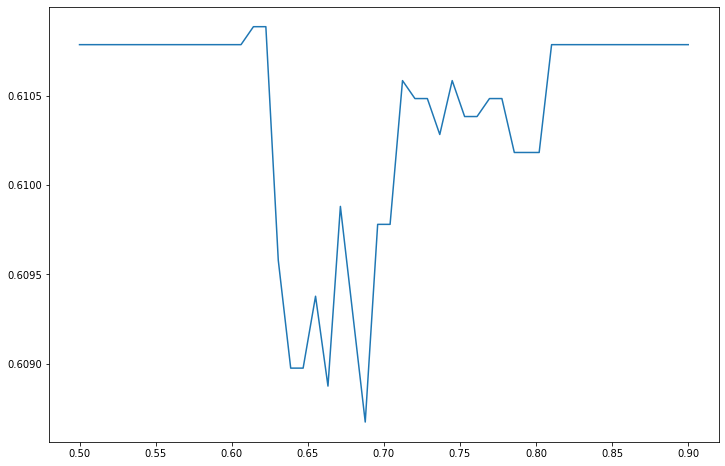

In [148]:
plt.figure(figsize=(12, 8))
plt.plot(acc_range, acc_list);

Not great. But what kind of accuracy do we get if we restrict to only those games where at least one has high enough scaled predicted probability?

In [157]:
acc_list = []
acc_range = np.linspace(0.5, 0.9, 50)

for acc in acc_range:
    main_cutoff, under_cutoff, over_cutoff = cutoff_by_acc(acc)
    sub_df = df[(df['xgb_main_proba_scaled']>main_cutoff)|(df['xgb_undersample_proba_scaled']>under_cutoff)|(df['xgb_oversample_proba_scaled']>over_cutoff)]
    y_test_sub = y_test.loc[sub_df.index]
    ensembled_preds = np.zeros_like(y_test_sub)
    for i in range(sub_df.shape[0]):
        if sub_df['xgb_main_proba_scaled'].iloc[i] > main_cutoff:
            ensembled_preds[i] = sub_df['xgb_pred'].iloc[i]
        elif sub_df['xgb_undersample_proba_scaled'].iloc[i] > under_cutoff:
            ensembled_preds[i] = sub_df['xgb_undersample_pred'].iloc[i]
        elif sub_df['xgb_oversample_proba_scaled'].iloc[i] > over_cutoff:
            ensembled_preds[i] = sub_df['xgb_oversample_pred'].iloc[i]
        else:
            print('Something went wrong')
            
    acc_list.append(accuracy_score(y_test_sub, ensembled_preds))

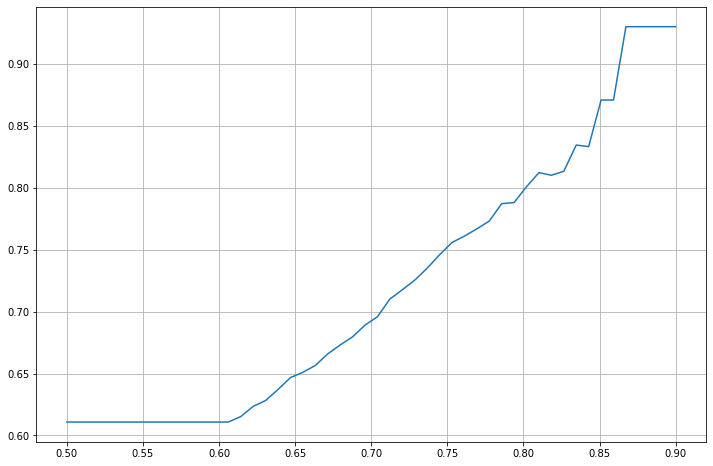

In [159]:
plt.figure(figsize=(12, 8))
plt.plot(acc_range, acc_list)
plt.grid();

Roughly linear, which is exactly what you would expect.

Finally, what happens if we train an XGB model on just the remaining columns? We then ensemble according to whether or not one of the above models has high enough scaled predicted probability.

In [161]:
df[df['xgb_proba'] < main_65_cutoff].shape[0]

263

In [162]:
train_df.head()

,Y,M,home_team,away_team,home_elo,away_elo,home_avg,away_avg,home_obp,away_obp,...,team_bayes_pct_diff,team_pytha_pct_diff,log_5,team_WHIP_pct_diff,xgb_train_pred,knn_no_batting_train_pred,nn_train_pred,home_win,add,should_drop
0,2001,4,TOR,TEX,1499.563,1479.163,0.273459,0.281519,0.339283,0.349386,...,0.0,0.000248,0.5,-0.083810,0.0,1.0,1,1.0,2.0,1
1,2001,4,SFN,SDN,1540.841,1492.800,0.276079,0.251828,0.359380,0.327088,...,0.0,0.000248,0.5,0.002172,1.0,1.0,1,1.0,3.0,1
2,2001,4,SEA,OAK,1519.464,1534.696,0.267280,0.268144,0.358599,0.357409,...,0.0,0.000248,0.5,-0.040048,0.0,1.0,1,1.0,2.0,1
3,2001,4,NYA,KCA,1529.511,1493.152,0.275080,0.285268,0.351633,0.344703,...,0.0,0.000248,0.5,-0.107743,1.0,1.0,1,1.0,3.0,1
4,2001,4,LAN,MIL,1515.925,1490.396,0.254198,0.243537,0.336984,0.322708,...,0.0,0.000248,0.5,-0.110116,1.0,1.0,1,1.0,3.0,1


In [163]:
train_df.columns

Index(['Y', 'M', 'home_team', 'away_team', 'home_elo', 'away_elo', 'home_avg',
       'away_avg', 'home_obp', 'away_obp', 'home_slg', 'away_slg', 'home_iso',
       'away_iso', 'elo_diff', 'elo_pct_diff', 'avg_diff', 'obp_diff',
       'slg_diff', 'team_avg_pct_diff', 'team_obp_pct_diff',
       'team_slg_pct_diff', 'home_rest', 'away_rest',
       'home_W-L-pct_offset1year', 'home_Avg_Attendance_offset1year',
       'home_Rank_offset1year', 'home_R_offset1year', 'home_RA_offset1year',
       'home_FP_offset1year', 'away_W-L-pct_offset1year',
       'away_Avg_Attendance_offset1year', 'away_Rank_offset1year',
       'away_R_offset1year', 'away_RA_offset1year', 'away_FP_offset1year',
       'home_WHIP_offset1year', 'home_ERA_offset1year',
       'away_WHIP_offset1year', 'away_ERA_offset1year',
       'home_pitcher_season_game', 'home_pitcher_WHIP_avg_162games',
       'home_pitcher_ERA_avg_162games', 'home_pitcher_IP_avg_162games',
       'home_pitcher_WPA_avg_162games', 'away_pitcher_se